In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
import time
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import sys
import os
import time
import pickle
from numba import jit
from scipy.optimize import rosen

%matplotlib inline

In [2]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def get_errors(x_, y_):
    return [np.sqrt(mse(x_, y_)), np.mean(np.abs(x_ - y_)), np.max(np.abs(x_ - y_))]

@jit
def simple_cov(_x, _y):
    return np.mean((_x-np.mean(_x))*(_y-np.mean(_y)), axis = 1)

def get_mcdues(X):
    stds = np.zeros((X.shape[0], params['T']), dtype = float)
    for cnt_ in range(params['T']):
        stds[:, cnt_] = np.ravel(sess.run(y, feed_dict={x: X, 
                                                        keep_probability_: .5}))
    return np.std(stds, axis = 1)

def get_stds(X):
    stds = np.zeros((X.shape[0], T), dtype = float)
    for cnt_ in range(T):
        stds[:, cnt_] = np.ravel(sess.run(y, feed_dict={x: X, 
                                                        keep_probability_: .5}))
    return stds

@jit
def compute_block_inv(A_inv, B, C, D):
    H = D - C.dot(A_inv).dot(B)
    H_inv = 1./ H
    a00 = A_inv + H_inv * A_inv.dot(B).dot(C).dot(A_inv)
    a01 = -A_inv.dot(B) * H_inv
    a10 = -H_inv * C.dot(A_inv)
    a11 = H_inv
    
    return np.block([[a00, a01.reshape(-1, 1)],
                    [a10.reshape((1, -1)), a11[0]]])

In [3]:
df = np.random.uniform(size=(1000, 2))
targets = rosen(df.T)

train_num = 500
thres = 800
thres2 = 1000


X_train = df[:train_num]
y_train = targets[:train_num][:, None]
X_pool = df[train_num:thres]
y_pool = targets[train_num:thres][:, None]
X_test = df[thres:thres2]
y_test = targets[thres:thres2][:, None]
print('train shapes:', X_train.shape, y_train.shape)
print('pool shapes:', X_pool.shape, y_pool.shape)
print('test shapes:', X_test.shape, y_test.shape)

train shapes: (500, 2) (500, 1)
pool shapes: (300, 2) (300, 1)
test shapes: (200, 2) (200, 1)


In [4]:
ndim = X_train.shape[1]
# layers = [64,32]
layers = [64,64,32]

learning_rate_decay = .97
start_learning_rate = 8e-4
learning_rate_schedule_epochs = 50000

$X$: batch_size $\times$ dim 

$W$: dim $\times$ 1


output: batch_size $\times$ 1

In [5]:
tf.reset_default_graph()

# placeholders
x = tf.placeholder(tf.float32, [None, ndim])
y_ = tf.placeholder(tf.float32, [None, 1])

learning_rate_ = tf.placeholder(tf.float32)
forces_coeff_ = tf.placeholder(tf.float32)
keep_probability_ = tf.placeholder(tf.float32, name='keep_probability')
l2_reg_ = tf.placeholder(tf.float32, name='l2reg')

# weights
W1 = tf.Variable(tf.truncated_normal([ndim, layers[0]], stddev=(2/ndim)**.5))
b1 = tf.Variable(tf.truncated_normal([layers[0]],  stddev=.1))
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
h_drop1 = tf.nn.dropout(h1, keep_probability_, noise_shape = [1,layers[0]])

Ws = [W1]; bs = [b1]; hs = [h_drop1]
for cnt_layer in range(1, len(layers)):
    Ws.append(tf.Variable(tf.truncated_normal([layers[cnt_layer - 1], layers[cnt_layer]], 
                                              stddev=(2/layers[cnt_layer - 1])**.5)))
    bs.append(tf.Variable(tf.truncated_normal([layers[cnt_layer]],  stddev=.1)))
    hs.append(tf.nn.dropout(tf.nn.relu(tf.matmul(hs[-1], Ws[-1]) + bs[-1]), keep_probability_,
                            noise_shape = [1,layers[cnt_layer]]))

Ws.append(tf.Variable(tf.truncated_normal([layers[-1], 1], stddev=.1)))
bs.append(tf.Variable(tf.truncated_normal([1],  stddev=.1)))

# funcs
y = tf.matmul(hs[-1], Ws[-1]) + bs[-1]

l2_regularizer = sum(tf.nn.l2_loss(Wxxx) for Wxxx in Ws) 

mse_e = tf.losses.mean_squared_error(predictions = y, labels = y_)
loss = mse_e + l2_reg_*l2_regularizer

#train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(loss)

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = start_learning_rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           learning_rate_schedule_epochs, learning_rate_decay, staircase=True)

lr_fun = lambda: learning_rate
min_lr = lambda: tf.constant(1e-5)
actual_lr = tf.case([(tf.less(learning_rate, tf.constant(1e-5)), min_lr)], default=lr_fun)

train_step = tf.train.AdamOptimizer(learning_rate=actual_lr).minimize(loss, global_step=global_step)

In [6]:
try:
    sess.close()
except:
    pass

init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)
epoch = 0
data = []

In [7]:
batch_size = 500
init_epochs = 50000
keep_prob = .95
l2_reg = 5e-5

al_steps = 20
uptrain_epochs = 1000000
mandatory_uptrain_epochs = 10000
sample_each_step = 250
T = 25

early_stopping_window = .03
max_warnings = 3
early_stopping_check_step = 100

gpnn_max_train = 1000
diag_eps = .01

In [8]:
X_train_current = X_train.copy()
y_train_current = y_train.copy()
X_pool_current = X_pool.copy()
y_pool_current = y_pool.copy()

# # Initial_training

In [9]:
lr, gs = sess.run([learning_rate, global_step])
print('learning rate: {:.4E}, global step: {}'.format(lr, gs))
prev_test_error = 1e+10
t = time.time()
for cnt in range(init_epochs):
    epoch += 1
    # training itself
    
    for batch in iterate_minibatches(X_train_current, y_train_current, batch_size):
        X_batch, y_batch = batch
        sess.run(train_step, feed_dict={x: X_batch, 
                                        y_: y_batch, 
                                        keep_probability_: keep_prob, 
                                        l2_reg_: l2_reg})
    # checking errors
    if (cnt+1) % early_stopping_check_step == 0:
        print(np.round(time.time() - t, 2), end='s')
        t = time.time()
        preds_train = sess.run(y, feed_dict={x: X_train_current, keep_probability_: 1})
        preds_test = sess.run(y, feed_dict= {x: X_test , keep_probability_: 1})
        
        train_err =  get_errors(preds_train, y_train_current)
        test_err =  get_errors(preds_test, y_test)
        print(' &', np.round(time.time() - t, 2), 's')
        print(epoch, np.round(train_err, 4), np.round(test_err, 4), end = '|')
        data.append([epoch] + train_err + test_err)
        # checking early stopping conditions
        if (test_err[0] > prev_test_error*(1 + early_stopping_window)) and (cnt > mandatory_uptrain_epochs):
            warnings += 1
            print('*'*warnings, end = '||')
            if warnings >= max_warnings:
                print('$$$')
                break
        else:
            warnings = 0
            prev_test_error = min(test_err[0], prev_test_error)
        t = time.time()
lr, gs = sess.run([learning_rate, global_step])
print('learning rate: {:.4E}, global step: {}'.format(lr, gs))

learning rate: 8.0000E-04, global step: 0
0.36s & 0.02 s
100 [20.8312 15.8748 69.6182] [22.9035 18.1545 68.289 ]|0.27s & 0.0 s
200 [13.0152 10.3623 58.8949] [13.7141 11.509  50.3027]|0.28s & 0.0 s
300 [ 7.9089  5.5362 42.4864] [ 7.9441  5.8475 36.4688]|0.25s & 0.0 s
400 [ 6.2125  4.3463 36.4977] [ 6.0077  4.3326 31.0206]|0.24s & 0.0 s
500 [ 5.5248  4.0503 29.8423] [ 4.8848  3.6263 24.5148]|0.27s & 0.01 s
600 [ 4.8393  3.298  32.1045] [ 4.6768  3.2296 27.0794]|0.25s & 0.0 s
700 [ 4.5383  3.3385 26.9907] [ 3.9885  2.878  22.1294]|0.26s & 0.0 s
800 [ 3.9512  2.7108 26.5155] [ 3.6966  2.5284 21.9707]|0.27s & 0.0 s
900 [ 4.2131  2.8961 26.2935] [ 4.174   2.8609 21.8765]|0.27s & 0.0 s
1000 [ 4.3706  3.155  24.1865] [ 4.3071  3.0251 19.9406]|0.27s & 0.0 s
1100 [ 3.1413  2.1758 21.1542] [ 2.828   1.9562 16.8925]|0.27s & 0.0 s
1200 [ 3.1558  2.3221 18.9304] [ 2.7634  2.005  14.8797]|0.26s & 0.0 s
1300 [ 2.6898  1.9114 18.4183] [ 2.4013  1.7093 14.4622]|0.39s & 0.0 s
1400 [ 2.5446  1.7562 18.539

In [10]:
fname_identifier = "rosenbrock_exp"
save_path = saver.save(sess, "/Users/Roman/Desktop/NNGP/init_" + fname_identifier + ".ckpt")
print("Init model saved in path: %s" % save_path)

Init model saved in path: /Users/Roman/Desktop/NNGP/init_rosenbrock_exp.ckpt


In [11]:
fname_identifier = "rosenbrock_exp"
saver.restore(sess, "/Users/Roman/Desktop/NNGP/init_" + fname_identifier + ".ckpt")
print("Init model restored")

INFO:tensorflow:Restoring parameters from /Users/Roman/Desktop/NNGP/init_rosenbrock_exp.ckpt
Init model restored


In [12]:
X_train_current = X_train.copy()
y_train_current = y_train.copy()
X_pool_current = X_pool.copy()
y_pool_current = y_pool.copy()

In [13]:
@jit
def dodot(Q, W):
    return np.dot(np.dot(Q.T, W), Q)[0][0]

@jit
def fxjit(x_cnt_):
    pool_sample = stds[(gpnn_max_train + x_cnt_), :]
    #t = time.time()
    Q = simple_cov(stds[:gpnn_max_train, :], pool_sample)[:, None]
    Q = Q.ravel()
    #print('Q in', np.round(time.time()-t, 2)); t=time.time()
    new_K_cov[-1, :-1] = Q
    new_K_cov[:-1, -1] = Q
    new_K_cov[-1, -1] = np.var(pool_sample)
    #print('Q insert in', np.round(time.time()-t, 2)); t=time.time()
    new_K_cov_inv = compute_block_inv(K_train_cov_inv,
                                      Q.reshape((-1, 1)),
                                      Q.reshape((1, -1)), 
                                      np.var(pool_sample) + 0.001)
    #print('new_K_cov_inv in', np.round(time.time()-t, 2)); t=time.time()
    indices = list(range(gpnn_max_train)) + [gpnn_max_train + x_cnt_]
    si = stds[indices]
    ### count sigma(v | X + x_from_pool) with extended 
    ### cov matrix for each v in vs
    extended_sigmas = np.zeros((len(y_vs),))
    for cnt_ in range(len(y_vs)):
        vs_sample = y_vs[cnt_, :]
        Q = simple_cov(si, vs_sample)[:, None]
        KK = np.var(vs_sample)
        #sigma = KK + params['diag_eps'] - np.dot(np.dot(Q.T, new_K_cov_inv), Q)[0][0]
        sigma = KK - dodot(Q, new_K_cov_inv) + diag_eps
        extended_sigmas[cnt_] = np.sqrt(sigma)
    return extended_sigmas
#     #print('integrate in', np.round(time.time()-t, 2)); t=time.time()
#     current_diff = np.array(sigmas) - np.array(extended_sigmas)
#     #print('misc in', np.round(time.time()-t, 2)); t=time.time()
#     return current_diff.sum()

In [25]:
extended_sigmas_list = []
sigmas_list = []
np.random.seed(0)

points_int_list = [10, 50, 100, 200, 300]

for points_to_integrate in points_int_list:

    gpnn_max_train = 100
    T = 25
    diag_eps = 0.001

    t = time.time()
    perm = np.random.permutation(range(len(X_train_current)))
    random_train_inds = perm[:gpnn_max_train]
    random_train_samples = X_train_current[random_train_inds]
    train_and_pool_samples = np.concatenate([random_train_samples, X_pool_current])    
    stds = get_stds(train_and_pool_samples)
    K_train_cov = np.cov(stds[:gpnn_max_train, :], ddof = 0)
    K_train_cov_inv = np.linalg.inv(K_train_cov + diag_eps * np.eye(gpnn_max_train))

    vs = X_pool_current[-points_to_integrate:,:]
    y_vs = get_stds(vs)
#     print('Work on sigmas at #', al_iters)
    ### sigma(v | X) for each v in vs
    sigmas = np.zeros((len(y_vs),))
    for cnt_ in range(len(vs)):
        vs_sample = y_vs[cnt_, :]
        Q = simple_cov(stds[:gpnn_max_train], vs_sample)[:, None]
        KK = np.var(vs_sample)
        sigma = KK - np.dot(np.dot(Q.T, K_train_cov_inv), Q)[0][0]
        sigmas[cnt_] = np.sqrt(sigma)

    diffs_integral = np.zeros(X_pool_current.shape[0])
    new_K_cov = np.zeros((gpnn_max_train + 1, gpnn_max_train + 1))
    new_K_cov[:gpnn_max_train, :gpnn_max_train] = K_train_cov

    for x_cnt_ in range(len(X_pool_current)-points_to_integrate):
        extended_sigmas = fxjit(x_cnt_)
        if x_cnt_ % 10 == 0:
            print(x_cnt_, end = '|')
            
    sigmas_list.append(sigmas)
    extended_sigmas_list.append(extended_sigmas)

0|10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|160|170|180|190|200|210|220|230|240|250|260|270|280|0|10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|160|170|180|190|200|210|220|230|240|0|10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|160|170|180|190|0|10|20|30|40|50|60|70|80|90|

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

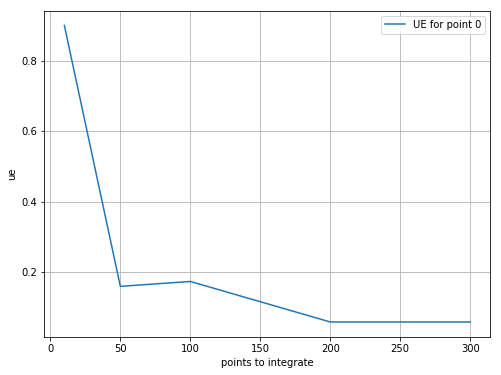

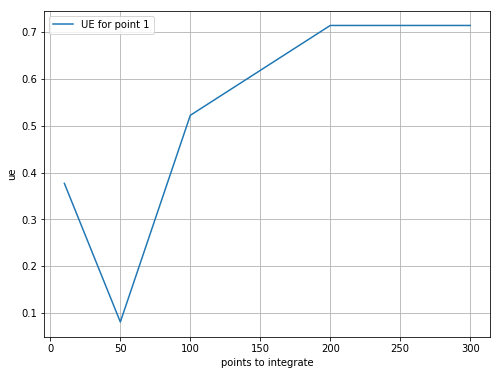

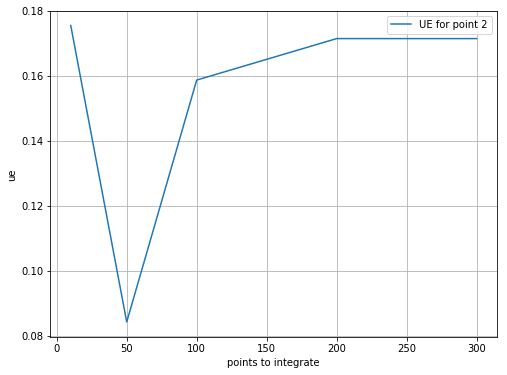

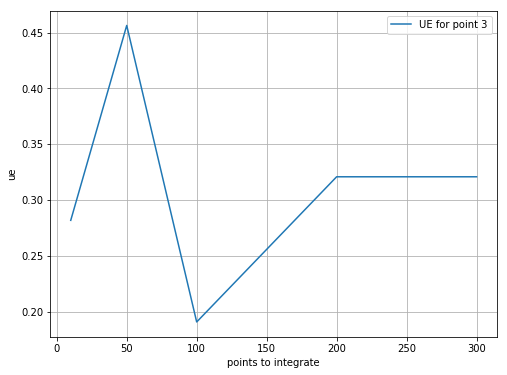

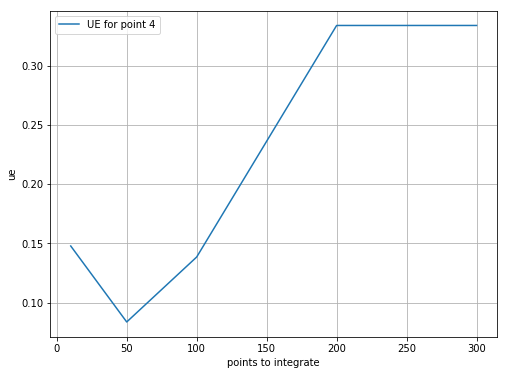

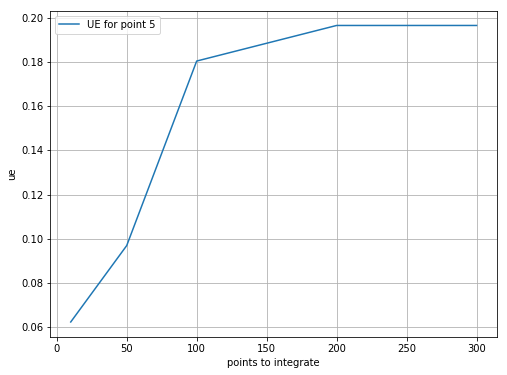

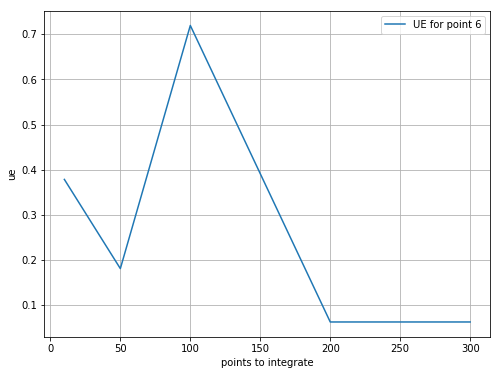

In [41]:
for i in range(7):
    idx_point = i
    ext_point_idx_values = [arr[idx_point] for arr in extended_sigmas_list]

    plt.figure(figsize=(8, 6))
    plt.plot(points_int_list, ext_point_idx_values, label="UE for point {}".format(idx_point))
    plt.xlabel("points to integrate")
    plt.ylabel("ue")
    plt.legend()
    plt.grid()